# Long Short-Term Memory Network with Keras

LSTM은 Backpropagation Through Time (BPTT)를 통해서 학습을 하며, vanishing gradient problem을 극복합니다.<br>
일반적인 Deep Learning에서 사용하는 Neurons들은 없고, layers들로 연결된 Memory Block을 갖고 있습니다. 

Block은 gates의 요소를 갖고 있으며, Gates는 block의 state를 관리하게 됩니다.<br>
일반적으로 다음과 같은 gates를 갖고 있습니다.

* Forget Gate: 어떤 정보를 버릴지 정합니다.
* Input Gate: Input 데이터에서 어떤 값들을 memory state에 업데이트할지 결정합니다.
* Output Gate: Input값과 memory block에 기초하여 어떤 결과값(output)을 낼지 결정합니다.


In [4]:
%pylab inline
import numpy as np
import pandas as pd
import os
import shutil
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import History, TensorBoard

from keras.utils.visualize_util import plot as keras_plot
from keras.utils.visualize_util import model_to_dot
from IPython.display import display
from IPython.display import SVG, Image

np.random.seed(0) # fix the random number

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Data

International Airline Pessengers

In [2]:
# Load Data
data = pd.read_csv('../../data/time-series/international-airline-passengers.csv', 
                   names=['passenger'],
                   skiprows=1, usecols=[1])

# Normalize Data using Min-Max Scaler 
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
data = data.astype('float32')

# Seperate Train and Test Data
_size = int(len(data) * 0.7) # 144
train, test = data[:_size], data[_size:] # 100, 44

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        dataX.append(dataset[i])
        dataY.append(dataset[i+1][0])
    return np.array(dataX), np.array(dataY)

look_back = 1
train_x, train_y = create_dataset(train, look_back)
test_x, test_y = create_dataset(test, look_back)

train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, train_x.shape[1]))

## LSTM Network Model

TensorBoard 는 다음과 같이 실행시킵니다.
```
tensorboard --logdir=/tmp/international_airline_passenger_logs
```

In [5]:
# History
tensorboard_filepath = '/tmp/international_airline_passenger_logs'
if os.path.exists(tensorboard_filepath):
    shutil.rmtree(tensorboard_filepath)

history = History()
tensorboard = TensorBoard('/tmp/international_airline_passenger_logs')

In [11]:
# Model
model = Sequential(name='LSTM Model')
model.add(LSTM(output_dim=5, input_dim=1))
model.add(Dense(output_dim=1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_x, train_y, nb_epoch=100, batch_size=1, verbose=2, callbacks=[history, tensorboard])

Epoch 1/100
0s - loss: 0.0350
Epoch 2/100
0s - loss: 0.0156
Epoch 3/100
0s - loss: 0.0118
Epoch 4/100
0s - loss: 0.0106
Epoch 5/100
0s - loss: 0.0096
Epoch 6/100
0s - loss: 0.0085
Epoch 7/100
0s - loss: 0.0075
Epoch 8/100
0s - loss: 0.0066
Epoch 9/100
0s - loss: 0.0056
Epoch 10/100
0s - loss: 0.0048
Epoch 11/100
0s - loss: 0.0042
Epoch 12/100
0s - loss: 0.0036
Epoch 13/100
0s - loss: 0.0031
Epoch 14/100
0s - loss: 0.0028
Epoch 15/100
0s - loss: 0.0025
Epoch 16/100
0s - loss: 0.0024
Epoch 17/100
0s - loss: 0.0022
Epoch 18/100
0s - loss: 0.0022
Epoch 19/100
0s - loss: 0.0021
Epoch 20/100
0s - loss: 0.0021
Epoch 21/100
0s - loss: 0.0021
Epoch 22/100
0s - loss: 0.0021
Epoch 23/100
0s - loss: 0.0021
Epoch 24/100
0s - loss: 0.0021
Epoch 25/100
0s - loss: 0.0021
Epoch 26/100
0s - loss: 0.0021
Epoch 27/100
0s - loss: 0.0021
Epoch 28/100
0s - loss: 0.0021
Epoch 29/100
0s - loss: 0.0020
Epoch 30/100
0s - loss: 0.0021
Epoch 31/100
0s - loss: 0.0021
Epoch 32/100
0s - loss: 0.0021
Epoch 33/100
0s -

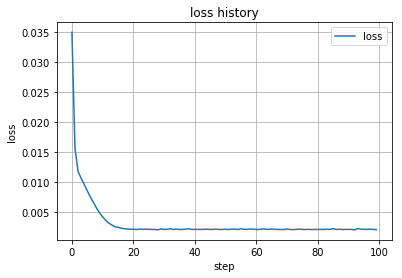

In [12]:
plot(history.history['loss'], label='loss')
title('loss history')
xlabel('step')
ylabel('loss')
grid()
legend()

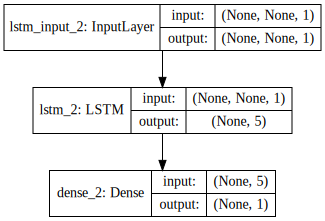

In [13]:
# # Visualization
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Evaluate

In [14]:
# Inverse Transform
train_predicted = scaler.inverse_transform(model.predict(train_x))
train_inv_x = scaler.inverse_transform(train_x.reshape(-1, 1))
train_inv_y = scaler.inverse_transform(train_y.reshape(-1, 1))

test_predicted = scaler.inverse_transform(model.predict(test_x))
test_inv_x = scaler.inverse_transform(test_x.reshape(-1, 1))
test_inv_y = scaler.inverse_transform(test_y.reshape(-1, 1))

# Reshape
train_predicted = train_predicted.reshape(train_predicted.shape[0])
test_predicted = test_predicted.reshape(test_predicted.shape[0])

# MSE
train_score = np.sqrt(mean_squared_error(train_predicted, train_inv_y))
test_score = np.sqrt(mean_squared_error(test_predicted, test_inv_y))

inv_data = scaler.inverse_transform(data)

print('Train RMSE:', train_score)
print('Test RMSE:', test_score)

Train RMSE: 23.5262
Test RMSE: 50.4615


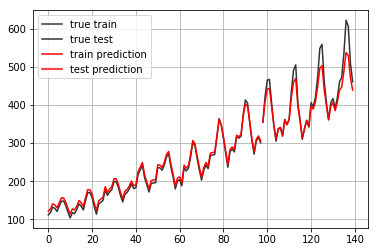

In [15]:

# Plot True data
x = range(len(train_inv_x) + len(test_inv_x))
p1 = x[:len(train_inv_x)], train_inv_x
p2 = x[len(train_inv_x): len(train_inv_x) + len(test_inv_x)], test_inv_x
plot(*p1, color='#333333', label='true train')
plot(*p2, color='#333333', label='true test')

# Plot Predictions
p3 = x[:len(train_predicted)], train_predicted
p4 = x[len(train_predicted): len(train_predicted) + len(test_predicted)], test_predicted
plot(*p3, color='red', label='train prediction')
plot(*p4, color='red', label='test prediction')
grid()

legend(loc='upper left')